# Multilayer Perceptron para a previsão de dados de precipitação

Aplicar também PCA?

Mensurar tempo de treino dos modelos

## Importação dos dados

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA

import time as t
import pickle

2025-06-09 16:30:21.649721: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 16:30:23.303753: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 16:30:24.139262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749497424.873109   37223 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749497425.071196   37223 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749497426.739165   37223 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
df = pd.read_csv("Banco de dados/inmet_filtrado_mirante.csv", index_col=0)

## Limpeza dos dados

### Normalização dos dados

A fórmula é: $\tilde{x_i} = \dfrac{x_{i} - \overline{x}}{\sigma}$

In [3]:
df.mean()

PRECIPITACAO TOTAL, HORARIO(mm)                     0.181972
TEMPERATURA DO PONTO DE ORVALHO(°C)                14.126436
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C)    14.627583
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C)    13.652489
UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)            71.875480
UMIDADE RELATIVA DO AR, HORARIA(%)                 69.346008
VENTO, RAJADA MAXIMA(m/s)                           5.225672
dtype: float64

In [4]:
df_norm = (df - df.mean())/df.std()
df_norm["PRECIPITACAO TOTAL, HORARIO(mm)"] = df["PRECIPITACAO TOTAL, HORARIO(mm)"]

In [5]:
df_norm.head(2)

,"PRECIPITACAO TOTAL, HORARIO(mm)",TEMPERATURA DO PONTO DE ORVALHO(°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),"UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, RAJADA MAXIMA(m/s)"
Data,,,,,,,
2010-10-10 00:00:00,0.0,-0.711163,-0.867264,-0.673133,0.902522,0.995876,0.757262
2010-10-10 01:00:00,0.0,-0.738240,-0.839535,-0.620390,0.902522,0.826644,0.373708


### Simplificação e separação dos dados

In [6]:
filtrar_ = lambda value: int(value > 0)

In [7]:
features = df_norm.columns[1:]

In [8]:
X = df_norm[features]
Y = df_norm['PRECIPITACAO TOTAL, HORARIO(mm)']
Y = Y.apply(filtrar_)

## Separação dos dados

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Criação do modelo

In [10]:
model = Sequential([
    Input(shape=(len(features),)), # Camada de Input
    Dense(4, activation="sigmoid"), # Camada oculta
    Dense(1, activation="sigmoid") # Camada de Output
])
model.summary()

2025-06-09 16:31:06.180314: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

O optimezer poderia ser uma string, no entanto, para brevidade nas explicações do relatório foi utlizado uma instância mesmo

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer=tf.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Treino e resultados

In [12]:
# Pula o treino se já houve um modelo salvo
if not glob.glob("mlp.keras"):
    t_i = t.time()
    mod = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), callbacks=[early_stopping])
    t_f = t.time()
    print("Tempo de execução: ", t_f - t_i)
    # Salvar o modelo e a history
    model.save("mlp.keras")
    with open("mlp_history.pkl", "wb") as f:
        pickle.dump(mod.history, f)
else:
    print("Modelo já treinado!")
    # Carregar o modelo e a history
    model = load_model("mlp.keras")
    with open("mlp_history.pkl", "rb") as f:
        mod = pickle.load(f)

Epoch 1/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9214 - loss: 0.4038 - val_accuracy: 0.9198 - val_loss: 0.2279
Epoch 2/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9203 - loss: 0.2173 - val_accuracy: 0.9198 - val_loss: 0.2024
Epoch 3/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9203 - loss: 0.1996 - val_accuracy: 0.9198 - val_loss: 0.1920
Epoch 4/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9207 - loss: 0.1901 - val_accuracy: 0.9241 - val_loss: 0.1859
Epoch 5/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9265 - loss: 0.1814 - val_accuracy: 0.9274 - val_loss: 0.1822
Epoch 6/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9299 - loss: 0.1814 - val_accuracy: 0.9284 - val_loss: 0.1798
Epoch 7/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9321 - loss: 0.1787 - val_accuracy: 0.9292 - val_loss: 0.1783
Epoch 8/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9301 - loss: 0

## Teste do modelo

In [13]:
results = model.evaluate(x_test, y_test, verbose=1)
print(f'Loss: {results[0]} - Acurácia: {results[1]}')

802/802 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9336 - loss: 0.1639
Loss: 0.1639910191297531 - Acurácia: 0.9342874884605408


### Visualização dos dados

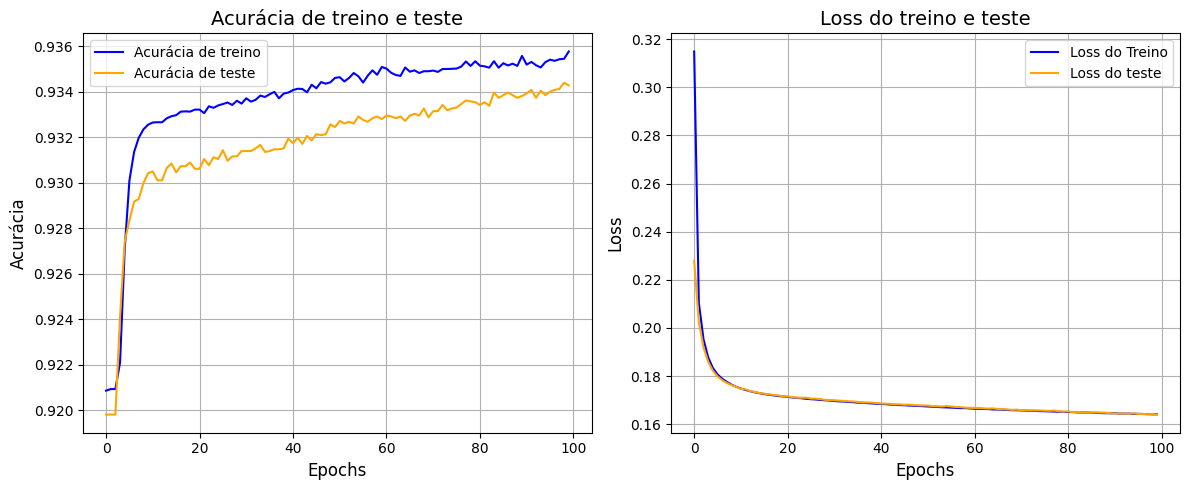

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mod.history['accuracy'], label='Acurácia de treino', color='blue')
plt.plot(mod.history['val_accuracy'], label='Acurácia de teste', color='orange')
plt.title('Acurácia de treino e teste', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mod.history['loss'], label='Loss do Treino', color='blue')
plt.plot(mod.history['val_loss'], label='Loss do teste', color='orange')
plt.title('Loss do treino e teste', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# plt.suptitle("Model Training Performance", fontsize=16)
plt.tight_layout()
plt.show()

### Matriz de confusão

In [15]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

802/802 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [16]:
y_pred_dicot = pd.Series(y_pred, y_test.index)
y_pred_dicot = (y_pred > 0.5).astype(int)

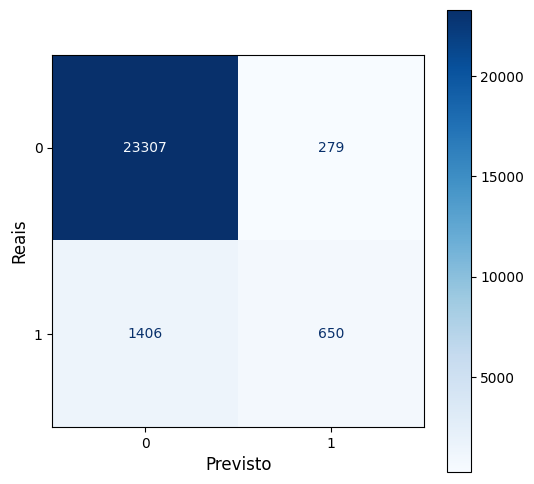

In [17]:
cm = confusion_matrix(y_test, y_pred_dicot)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(6, 6))
cm_disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_xlabel('Previsto', fontsize=12)
ax.set_ylabel('Reais', fontsize=12)
plt.show()

Confirmação dos valores da matriz de ocnfusão

In [18]:
print("Acurácia total:", (23327 + 629)/len(y_pred_dicot))

Acurácia total: 0.9342484985570548


## Weight e Bias

### Camada oculta

In [19]:
weights, biases = model.layers[0].get_weights()

Note que está transposto!

In [20]:
weights.shape

(6, 4)

1 bias por neurônio

In [21]:
biases.shape

(4,)

Formato em LaTex:

\begin{bmatrix}
1 & 2 & 3\\
a & b & c
\end{bmatrix}

In [22]:
weights.T

array([[-0.04528233, -0.6461858 ,  0.90616035, -0.09261219, -3.1849473 ,
        -0.0806861 ],
       [-0.86329645, -3.1232634 ,  2.969014  ,  1.231408  , -1.6760656 ,
        -0.61390126],
       [ 0.62877613, -1.9004446 ,  0.62525964, -3.5773263 , -0.50232285,
        -0.2576678 ],
       [ 0.9630377 ,  2.8927972 , -4.482057  , -0.5209613 ,  0.65998226,
         0.09177005]], dtype=float32)

Pesos

In [23]:
print("\\begin{bmatrix}")
for linha in weights.T:
    linha_str = [str(el) for el in linha]
    print(" & ".join(linha_str), end=" ")
    print("\\\\")
print("\\end{bmatrix}")

\begin{bmatrix}
-0.04528233 & -0.6461858 & 0.90616035 & -0.09261219 & -3.1849473 & -0.0806861 \\
-0.86329645 & -3.1232634 & 2.969014 & 1.231408 & -1.6760656 & -0.61390126 \\
0.62877613 & -1.9004446 & 0.62525964 & -3.5773263 & -0.50232285 & -0.2576678 \\
0.9630377 & 2.8927972 & -4.482057 & -0.5209613 & 0.65998226 & 0.09177005 \\
\end{bmatrix}


Biases

In [24]:
print("\\begin{bmatrix}")
linha_str = [str(el) for el in biases.T]
print("\\\\\n".join(linha_str))
print("\\end{bmatrix}")

\begin{bmatrix}
3.1030707\\
1.0726142\\
1.7111365\\
1.0201999
\end{bmatrix}


### Camada de Output

In [25]:
weights, biases = model.layers[1].get_weights()

In [26]:
weights.shape

(4, 1)

In [27]:
biases.shape

(1,)

Pesos

In [28]:
print("\\begin{bmatrix}")
linha_str = [str(el) for el in weights.T.flatten()]
print("\\\\\n".join(linha_str))
print("\\end{bmatrix}")

\begin{bmatrix}
-3.3368704\\
-3.7269504\\
-3.6255038\\
4.1293035
\end{bmatrix}


Biases

In [29]:
print("\\begin{bmatrix}")
linha_str = [str(el) for el in biases.T]
print("\\\\\n".join(linha_str))
print("\\end{bmatrix}")

\begin{bmatrix}
0.4111217
\end{bmatrix}


## Treino com o PCA (OBSOLETO)

In [30]:
pca = PCA()

In [31]:
df_proj = pca.fit_transform(df_norm.drop("PRECIPITACAO TOTAL, HORARIO(mm)", axis=1))
df_proj = pd.DataFrame(df_proj, columns=pca.get_feature_names_out())

In [32]:
df_proj = df_proj.drop(["pca2", "pca3", "pca4", "pca5"], axis=1)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(df_proj, Y, test_size=0.2, random_state=42)

In [34]:
model = Sequential([
    Input(shape=(2,)), # Camada de Input
    Dense(12, activation="sigmoid"), # Camada oculta
    Dense(1, activation="sigmoid") # Camada de Output
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 12)             │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
t_i = t.time()
mod = model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), callbacks=[early_stopping])
t_f = t.time()
print("Tempo de execução: ", t_f - t_i)


Epoch 1/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9214 - loss: 0.3394 - val_accuracy: 0.9198 - val_loss: 0.2329
Epoch 2/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9203 - loss: 0.2290 - val_accuracy: 0.9198 - val_loss: 0.2271
Epoch 3/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9197 - loss: 0.2269 - val_accuracy: 0.9198 - val_loss: 0.2267
Epoch 4/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9206 - loss: 0.2253 - val_accuracy: 0.9198 - val_loss: 0.2268
Epoch 5/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9214 - loss: 0.2241 - val_accuracy: 0.9198 - val_loss: 0.2264
Epoch 6/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9204 - loss: 0.2252 - val_accuracy: 0.9198 - val_loss: 0.2264
Epoch 7/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9207 - loss: 0.2258 - val_accuracy: 0.9198 - val_loss: 0.2261
Epoch 8/100
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9210 - loss: 0

In [36]:
results = model.evaluate(x_test, y_test, verbose=0)
print('Loss, Acurácia:', results)

Loss, Acurácia: [0.22223353385925293, 0.9202480316162109]


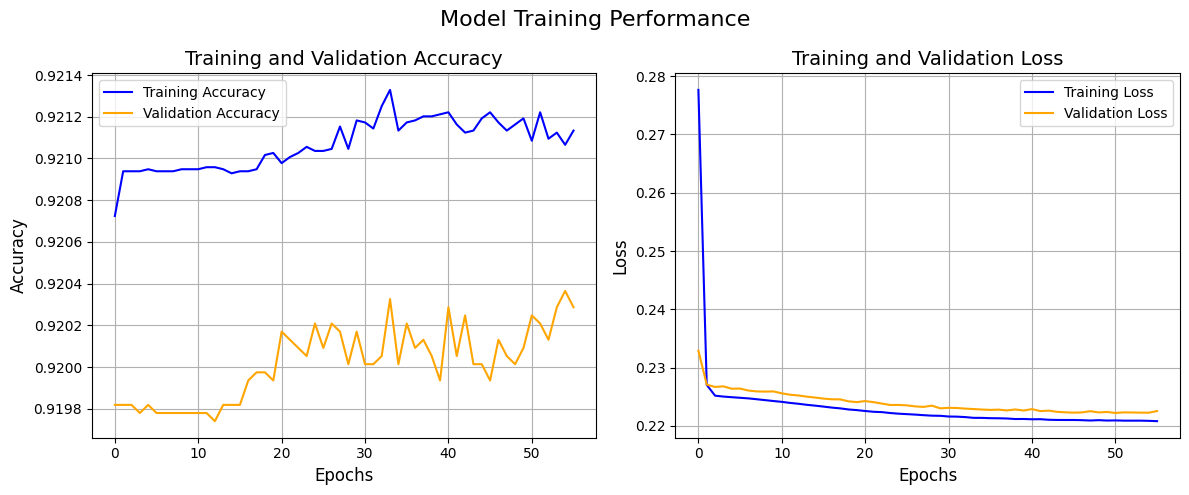

In [37]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mod.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(mod.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mod.history['loss'], label='Training Loss', color='blue')
plt.plot(mod.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

plt.suptitle("Model Training Performance", fontsize=16)
plt.tight_layout()
plt.show()

### Coeficientes (*Weights* e *biases*)

### Layer 0 - Input

In [38]:
weights, biases = model.layers[0].get_weights()

In [39]:
weights

array([[-0.77303505,  0.62407327,  0.5640077 ,  0.666307  , -0.75681263,
        -0.94305724, -0.8880444 , -0.7174917 ,  0.2535278 , -0.74166185,
        -0.16515541, -1.0457175 ],
       [ 0.54882425, -0.49965096, -0.30150592, -0.47979528,  0.5636352 ,
         0.4640849 ,  0.16459574,  0.5490429 ,  1.8329374 ,  0.53165215,
         1.5830252 , -1.4243484 ]], dtype=float32)

In [40]:
biases

array([ 0.34170264, -0.096979  , -0.3328189 , -0.24623305,  0.05894628,
        0.69196165,  0.89637154,  0.26540327, -2.543398  ,  0.27194005,
        0.7916062 ,  3.9250853 ], dtype=float32)

In [41]:
weights.shape

(2, 12)

In [42]:
biases.shape

(12,)

In [43]:
weights, biases = model.layers[1].get_weights()

In [44]:
weights.shape

(12, 1)

In [45]:
biases.shape

(1,)